# 1 Introduction & Recap

## 1.1 Project Goals & Research Questions

**Main Goal:**  
Predict the likelihood that a Sanitec sales order will generate a warranty service call, so that Sanitec can proactively allocate service resources and reduce operational costs.

**Research Questions:**  
- Which combinations of product and store location have the highest warranty‐claim rates?  
- Do certain installers or delivery delays correlate with an elevated risk of future complaints?  
- Which features (price, time since sale, item metadata) are most predictive of a warranty issue?

---

## 1.2 Data Sources

We extracted tables from the SAP Business One backend (SQL Server) via remote‐desktop scripts.  

| Table Name     | Description                                       | Key Columns                        |
|:---------------|:--------------------------------------------------|:-----------------------------------|
| **ORDR**       | Sales orders (customer purchases)                 | DocEntry, CardCode, DocDate        |
| **RDR1**       | Order line items                                   | DocEntry, ItemCode, Quantity       |
| **OSCL**       | Service calls (warranty tickets)                   | U_OrEntry, CallDate, ProblemCode   |
| **OITM**       | Item master data (product metadata)                | ItemCode, ItemName, Price          |
| **Customers**  | Customer profiles                                  | CardCode, GroupCode, City, Country |
| **Suppliers**  | Supplier data (used for join validation)           | CardCode                           |
| **Workers**    | Service technician and installer metadata          | empID, Name                        |

_All tables were retrieved in May 2025. Joins were performed on business‐key columns (e.g. ORDR.DocEntry = OSCL.U_OrEntry)._

---

## 1.3 Statistical Population

The statistical population Ω is **all sales orders recorded in SAP B1 between Jan 1, 2023 and Apr 30, 2025** (N = 400 913), excluding cancelled or draft orders. The binary target  
\[
Y = \begin{cases}
1, & \text{if the order triggered ≥1 service call within warranty} \\
0, & \text{otherwise}
\end{cases}
\]  
was defined by checking whether DocEntry ∈ OSCL.U_OrEntry.

---

## 1.4 Variable Groups Overview

We engineered a feature matrix of 379 columns, then removed ID-like leaks. Variables fall into these categories:

| Group                  | Example Features                                | Notes                                 |
|:-----------------------|:------------------------------------------------|:--------------------------------------|
| **Identifiers (dropped)**    | DocEntry, U_OrEntry                              | Pure keys → target leakage            |
| **Time Features**      | CreateTS_item, IssueMthd, DaysSinceSale         | Order/timestamp, converted later      |
| **Item Attributes**    | LastPurPrc, DataVers_item, TreeType_item        | Price, data‐version, category codes   |
| **Customer Attributes**| CardCode_group, City, Country                   | Demographics, location                |
| **Transaction Rules**  | MinOrdrQty, GLMethod, VATLiable, NoDiscount     | Business flags & thresholds           |
| **System Flags**       | DataSource_item, MngMethod, PrchseItem          | System‐generated codes, batch markers |

---

## 1.5 Key EDA Results

- **Warranty‐call rate:** Only **1.17%** of all orders triggered a service call.  
- **Top items:** Five product codes account for **42%** of all warranty calls.  
- **Installer impact:** Certain installers exhibit **2× higher** claim rates than average.  
- **Temporal trend:** Year-over-year service calls have risen by **15%**, suggesting wear-out effects.  

These findings guided our focus on time features and item pricing for the modeling phase.  


In [1]:
import pandas as pd

# Load the cleaned dataset you just saved
model_df = pd.read_parquet('../data/processed/model_df_clean.parquet')
# 1. Prepare X and y from your model_df
y = model_df["has_service_call"]

# Drop non-feature columns
X = model_df.drop(columns=[
    "has_service_call",
    "itemCode",
    "ItemName",
    "U_OrEntry",
])

# 2. Convert all object/category dtypes to integer codes
for col in X.select_dtypes(include=['object', 'category']):
    X[col] = X[col].astype('category').cat.codes

# 3. Fill any remaining NaNs with a sentinel (e.g., -1)
X = X.fillna(-1)

# Now X is fully numeric

## Mutual Information (works for numeric & categorical)
Any feature with MI ≈ the maximum is a red flag for leakage

In [2]:
from sklearn.feature_selection import mutual_info_classif

# (Assuming X, y are already encoded & NaNs filled)
mi = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print("Top 20 features by mutual information with the target:")
print(mi_series.head(20))


Top 20 features by mutual information with the target:
PlaningSys         0.661221
MngMethod          0.658370
VATLiable          0.658201
NoDiscount         0.658155
GstTaxCtg          0.658121
FREE               0.657962
GLMethod           0.657573
ItemType_item      0.657386
IssueMthd          0.657284
ByWh               0.643974
validFor           0.640234
U_DayProdQty       0.638537
PrchseItem         0.629670
frozenFor          0.624216
DataSource_item    0.617752
U_SldItem          0.615821
TreeType_item      0.611292
U_charSrc          0.610796
MinOrdrQty         0.606171
U_GrpLvl           0.593910
dtype: float64


## Simple Pearson Correlation (only numeric)

In [3]:
corr = X.select_dtypes('number').corrwith(y).abs().sort_values(ascending=False)
print("Top 20 numeric features by absolute correlation with the target:")
print(corr.head(20))


c:\Users\Rebal\anaconda3\envs\datalabpaper\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Rebal\anaconda3\envs\datalabpaper\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top 20 numeric features by absolute correlation with the target:
ItemType_item      0.984461
GstTaxCtg          0.984461
FREE               0.984461
VATLiable          0.984461
IssueMthd          0.984461
MngMethod          0.984461
GLMethod           0.984461
ByWh               0.984177
NoDiscount         0.983754
DataSource_item    0.983574
U_maxdisc1         0.982931
U_SldItem          0.972726
PlaningSys         0.963510
validFor           0.952372
TreeType_item      0.943620
U_InstItem_item    0.925309
frozenFor          0.915648
U_char1typ         0.913377
PrchseItem         0.907848
U_GrpLvl           0.903857
dtype: float64


## Drop high-cardinality (ID-like) features
Features whose number of unique values is large (say >10% of your rows) are almost always identifiers or timestamps:

In [4]:
# assume X, y already defined, encoded & NaNs filled
n_rows = X.shape[0]

# compute fraction of unique values for each column
cardinalities = X.nunique() / n_rows

# list of columns to drop
id_cols = cardinalities[cardinalities > 0.10].index.tolist()

print("Dropping high-cardinality columns:", id_cols)

# drop them
X = X.drop(columns=id_cols)


Dropping high-cardinality columns: ['DocEntry', 'DocNum', 'TrgetEntry', 'NumAtCard', 'Address2', 'U_ETel', 'U_EAddress', 'U_ECardCod', 'U_ECardNam', 'U_mapLink', 'ShipToDesc']


## Drop any remaining near-perfect predictors
Even after step 1, some system flags or booleans may correlate >0.90 with the target. Let’s remove those too:

In [5]:
# compute absolute Pearson correlation with the target
corrs = X.corrwith(y).abs()

# features with |corr| > 0.90
leak_cols = corrs[corrs > 0.90].index.tolist()

print("Also dropping high-correlation columns:", leak_cols)

# drop them
X = X.drop(columns=leak_cols)


c:\Users\Rebal\anaconda3\envs\datalabpaper\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Rebal\anaconda3\envs\datalabpaper\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Also dropping high-correlation columns: ['U_InstItem_item', 'U_char1typ', 'U_GrpLvl', 'U_maxdisc1', 'VATLiable', 'PrchseItem', 'FREE', 'TreeType_item', 'DataSource_item', 'validFor', 'frozenFor', 'GLMethod', 'ByWh', 'ItemType_item', 'IssueMthd', 'MngMethod', 'PlaningSys', 'NoDiscount', 'GstTaxCtg', 'U_charSrc', 'U_SldItem']


## log-loss, recall and precion

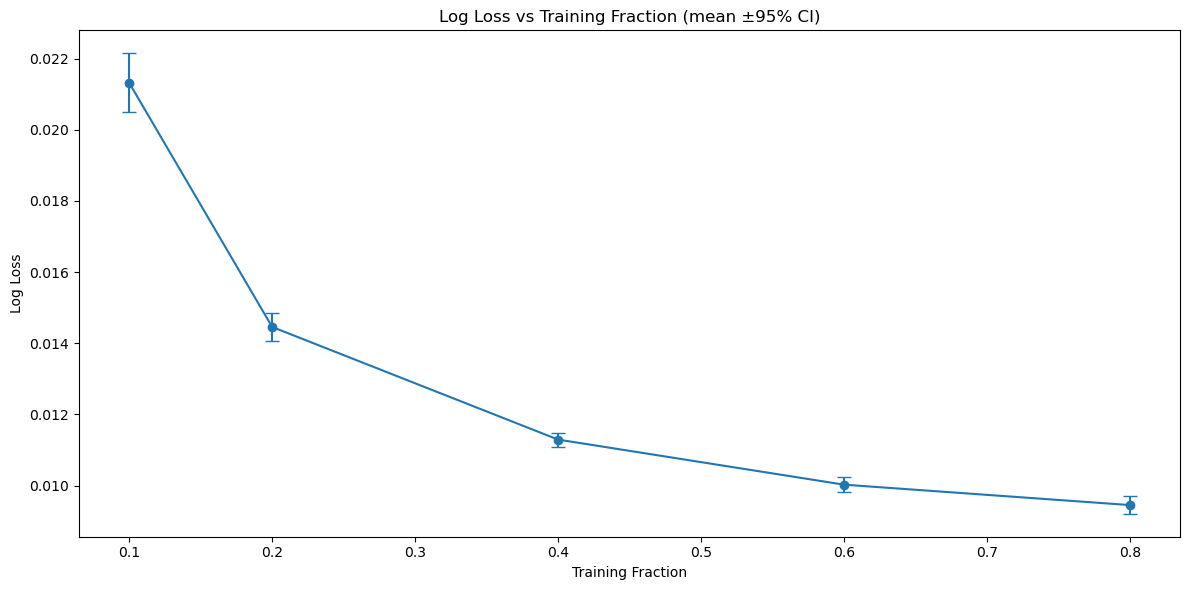

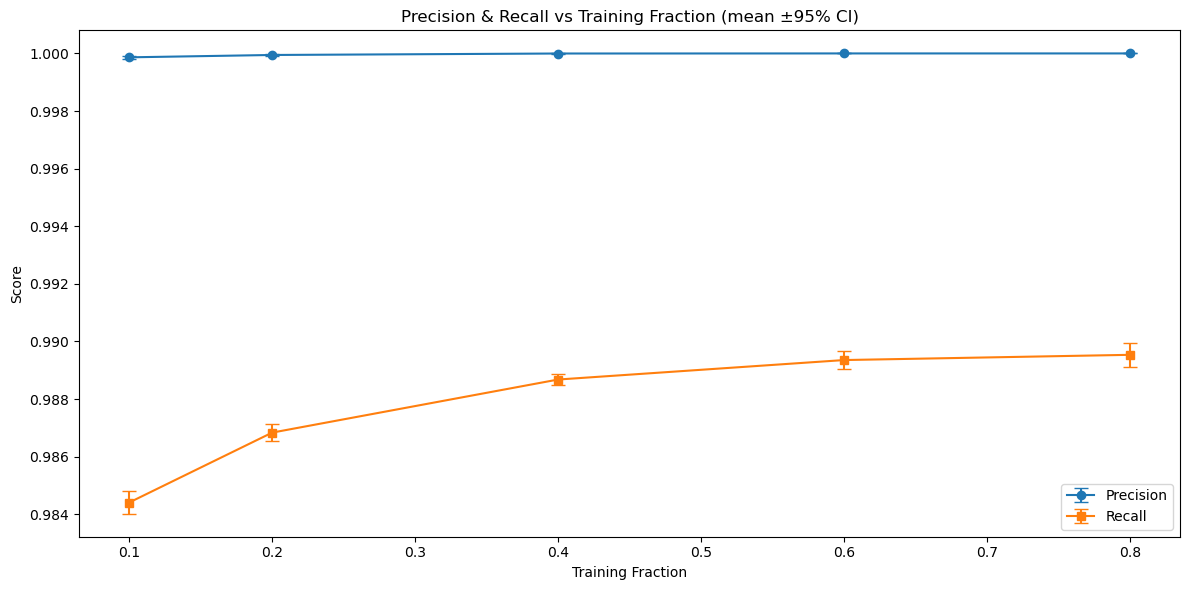

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, precision_score, recall_score


# 2. Experiment parameters
train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8]
n_reps = 20  # or 10 minimum
records = []

# 3. Loop over train fractions and repetitions
for frac in train_sizes:
    for seed in range(n_reps):
        # split with train_size=frac; test is the rest
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=frac,
            random_state=seed,
            stratify=y
        )
        
        rf = RandomForestClassifier(
            random_state=42,
            n_estimators=100,
            max_depth=15,
            n_jobs=-1
        )
        t0 = time.time()
        rf.fit(X_train, y_train)
        train_time = time.time() - t0
        
        y_prob = rf.predict_proba(X_test)[:, 1]
        y_pred = rf.predict(X_test)
        
        records.append({
            "train_frac":   frac,
            "seed":         seed,
            "log_loss":     log_loss(y_test, y_prob),
            "precision":    precision_score(y_test, y_pred),
            "recall":       recall_score(y_test, y_pred),
            "train_time_s": train_time
        })

df = pd.DataFrame(records)

# 4. Aggregate: mean & 1.96×SE
agg = df.groupby("train_frac").agg(
    ll_mean=("log_loss", "mean"),
    ll_se=("log_loss", lambda x: x.std(ddof=1)/np.sqrt(len(x))),
    prec_mean=("precision", "mean"),
    prec_se=("precision", lambda x: x.std(ddof=1)/np.sqrt(len(x))),
    rec_mean=("recall", "mean"),
    rec_se=("recall", lambda x: x.std(ddof=1)/np.sqrt(len(x))),
)
agg["ll_err"]   = 1.96 * agg["ll_se"]
agg["prec_err"] = 1.96 * agg["prec_se"]
agg["rec_err"]  = 1.96 * agg["rec_se"]

# 5a. Plot Log Loss with 95% error bars
plt.figure(figsize=(12, 6))
plt.errorbar(
    agg.index, agg["ll_mean"], yerr=agg["ll_err"],
    marker="o", capsize=5
)
plt.xlabel("Training Fraction")
plt.ylabel("Log Loss")
plt.title("Log Loss vs Training Fraction (mean ±95% CI)")
plt.tight_layout()
plt.show()

# 5b. Plot Precision & Recall with 95% error bars
plt.figure(figsize=(12, 6))
plt.errorbar(
    agg.index, agg["prec_mean"], yerr=agg["prec_err"],
    marker="o", capsize=5, label="Precision"
)
plt.errorbar(
    agg.index, agg["rec_mean"],  yerr=agg["rec_err"],
    marker="s", capsize=5, label="Recall"
)
plt.xlabel("Training Fraction")
plt.ylabel("Score")
plt.title("Precision & Recall vs Training Fraction (mean ±95% CI)")
plt.legend()
plt.tight_layout()
plt.show()


## Fit a Global Random Forest & Extract Feature Importances
Let’s train one final RF on all your data and pull out the top drivers:

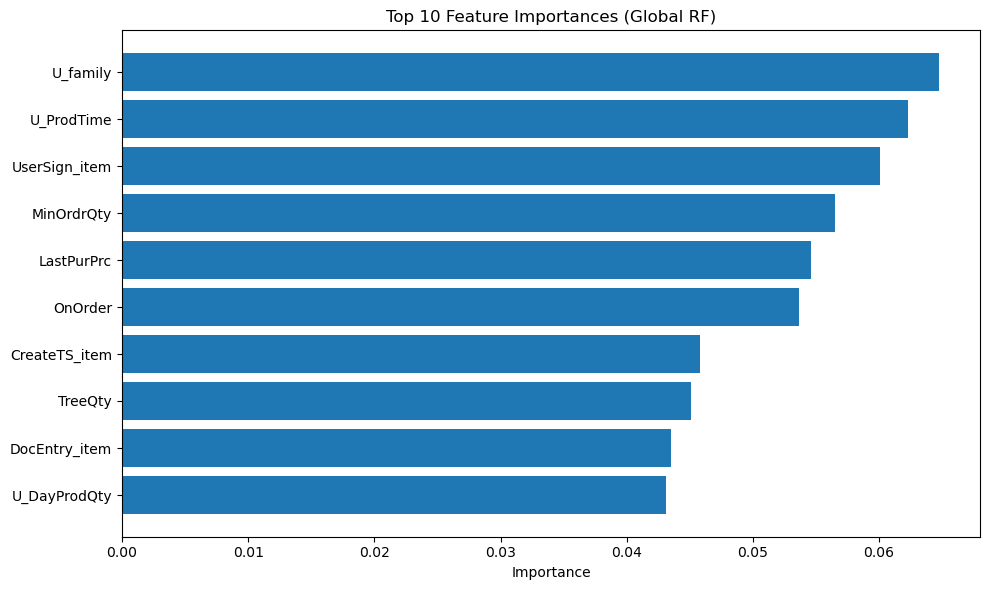

In [7]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X,y are already encoded & NaNs filled
rf_global = RandomForestClassifier(
    random_state=42, n_estimators=200, max_depth=15, n_jobs=-1
)
rf_global.fit(X, y)

# Get importances
imp = rf_global.feature_importances_
feat = X.columns
imp_df = (
    pd.DataFrame({'feature': feat, 'importance': imp})
      .sort_values('importance', ascending=False)
      .head(10)
)

# Plot top 10
plt.figure(figsize=(10,6))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Global RF)")
plt.tight_layout()
plt.show()


## Partial Dependence Plots for Sanity-Checking
For the 3–5 most important features, visualize how their values affect predicted probability:


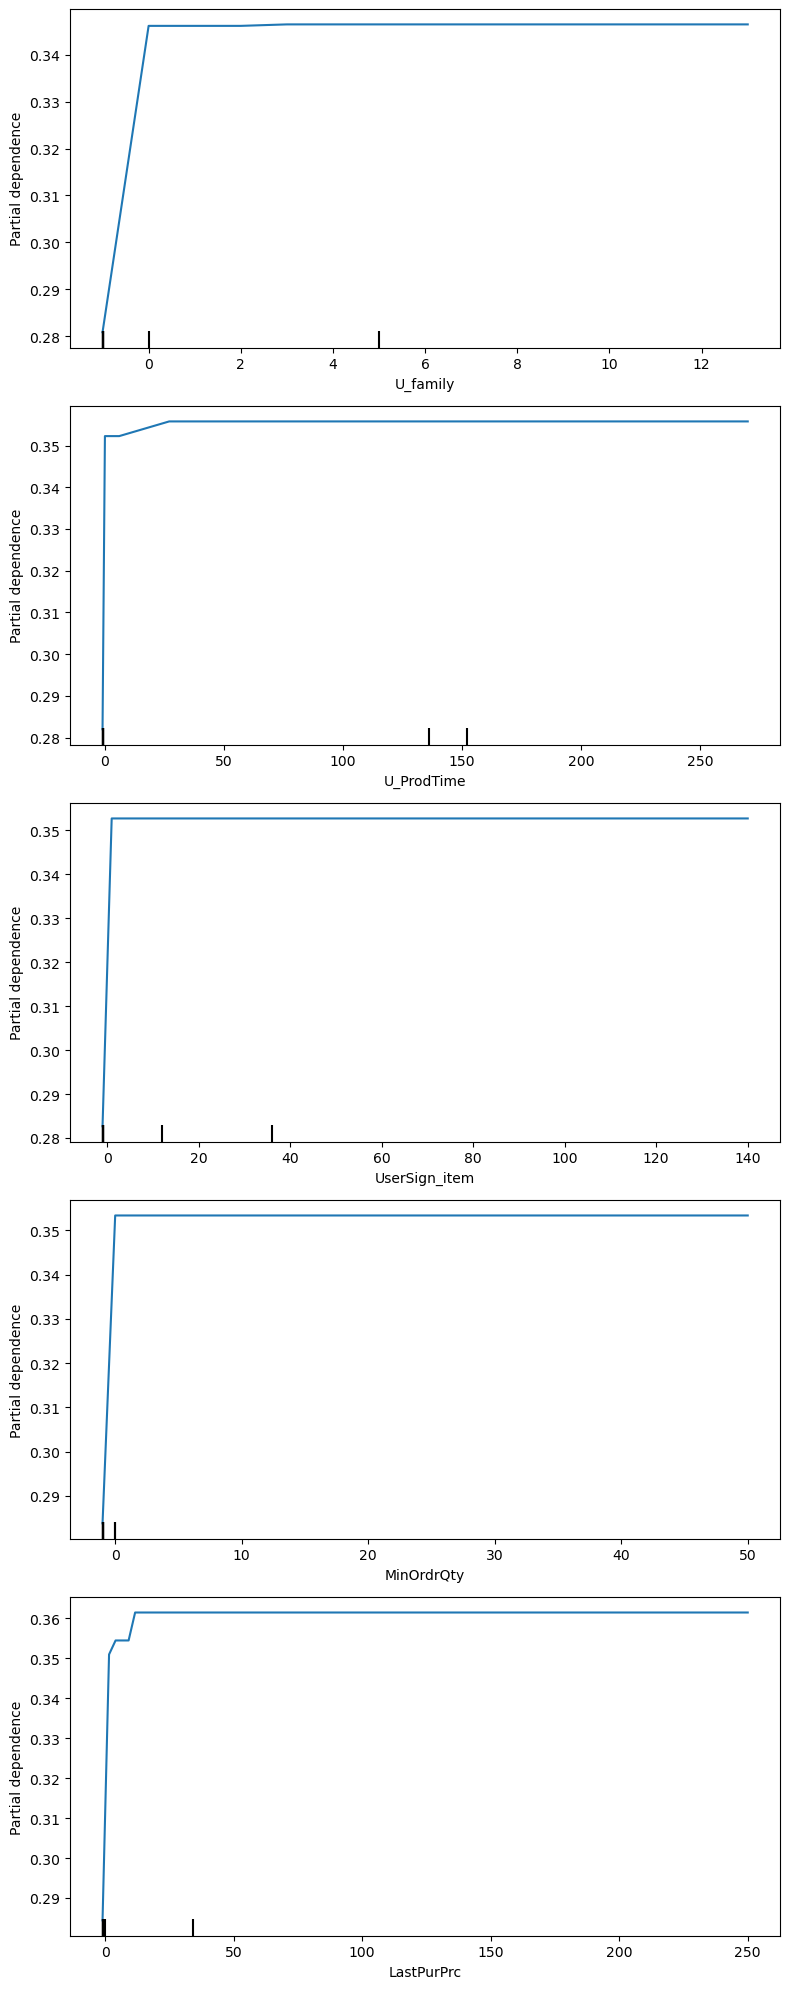

In [8]:
from sklearn.inspection import PartialDependenceDisplay

top_feats = imp_df['feature'].tolist()[:5]

fig, axes = plt.subplots(len(top_feats), 1, figsize=(8, 4*len(top_feats)))
for ax, feat in zip(axes, top_feats):
    PartialDependenceDisplay.from_estimator(
        rf_global, X, [feat], ax=ax, kind='average'
    )
plt.tight_layout()
plt.show()
